In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Charles Dickens
### Great Expectations

In [2]:
BODY_START = 45
BODY_END = 20056
CHAP_PAT = r'^\s*(?:Chapter).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/Great_ Expectations.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['Chapter I\n',
 '\n',
 "My father's family name being Pirrip, and my Christian name Philip, my\n",
 'infant tongue could make of both names nothing longer or more explicit\n',
 'than Pip. So, I called myself Pip, and came to be called Pip.\n',
 '\n',
 "I give Pirrip as my father's family name, on the authority of his\n",
 'tombstone and my sister,--Mrs. Joe Gargery, who married the blacksmith.\n',
 'As I never saw my father or my mother, and never saw any likeness\n',
 'of either of them (for their days were long before the days of\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,Chapter I\n
1,\n
2,"My father's family name being Pirrip, and my C..."
3,infant tongue could make of both names nothing...
4,"than Pip. So, I called myself Pip, and came to..."


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 45,
    body_end = 20056,
    chap_pat = r'^\s*(?:Chapter).*$'
)
GE_K, GE_V = text_to_tokens(**cfg)

In [12]:
GE_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0            NN   Chapter     0    0  chapter   
                           1           PRP         I     0    0        i   
         1        0        0          PRP$        My     0    0       my   
                           1            NN    father     0    0   father   
                           2           POS        's     0    0       's   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1562  
                           1             4816  
         1        0        0             6237  
                           1             3638  
                           2               54

In [13]:
GE_K = GE_K.loc[GE_K.term_id >= 0]

In [14]:
GE_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0            NN   Chapter     0    0  chapter   
                           1           PRP         I     0    0        i   
         1        0        0          PRP$        My     0    0       my   
                           1            NN    father     0    0   father   
                           2           POS        's     0    0       's   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1562  
                           1             4816  
         1        0        0             6237  
                           1             3638  
                           2               54

In [15]:
GE_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,'account,1,0.000005,'account,0
1,'air,1,0.000005,'air,0
2,'and,6,0.000032,'and,0
3,'arm,1,0.000005,'arm,0
4,'as,1,0.000005,'a,0


In [16]:
WORDS = (GE_K.punc == 0) & (GE_K.num == 0) & GE_K.term_id.isin(GE_V[GE_V.stop==0].index)

In [17]:
BOW = GE_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10803,10804,10806,10810,10811,10812,10813,10814,10815,10816
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * GE_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
GE_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / GE_V[GE_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10803,10804,10806,10810,10811,10812,10813,10814,10815,10816
chap_num,,,,,,,,,,,,,,,,,,,,,
0,6.730630e-09,6.730630e-09,4.442328e-09,6.730630e-09,6.730630e-09,5.586479e-09,6.730630e-09,4.917194e-09,6.730630e-09,6.730630e-09,...,0.005365,3.518593e-09,4.442328e-09,3.298178e-09,5.586479e-09,6.730630e-09,6.730630e-09,5.586479e-09,6.730630e-09,6.730630e-09
1,3.591333e-09,3.591333e-09,2.370340e-09,3.591333e-09,3.591333e-09,2.980837e-09,3.591333e-09,2.623719e-09,3.591333e-09,3.591333e-09,...,0.001670,1.877453e-09,2.370340e-09,1.759844e-09,2.980837e-09,3.591333e-09,3.591333e-09,2.980837e-09,3.591333e-09,3.591333e-09
2,6.715263e-09,6.715263e-09,4.432186e-09,6.715263e-09,6.715263e-09,5.573725e-09,6.715263e-09,4.905967e-09,6.715263e-09,6.715263e-09,...,0.001784,3.510560e-09,4.432186e-09,3.290648e-09,5.573725e-09,6.715263e-09,6.715263e-09,5.573725e-09,6.715263e-09,6.715263e-09
3,3.580404e-09,3.580404e-09,2.363127e-09,3.580404e-09,3.580404e-09,2.971766e-09,3.580404e-09,2.615735e-09,3.580404e-09,3.580404e-09,...,0.001189,1.871741e-03,2.363127e-09,1.754490e-03,2.971766e-09,3.580404e-09,3.580404e-09,2.971766e-09,3.580404e-09,3.580404e-09
4,2.996745e-09,2.996745e-09,1.977902e-09,2.996745e-09,2.996745e-09,2.487324e-09,2.996745e-09,2.189331e-09,2.996745e-09,2.996745e-09,...,0.000796,1.566618e-09,1.977902e-09,1.468480e-09,2.487324e-09,2.996745e-09,2.996745e-09,2.487324e-09,2.996745e-09,2.996745e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10803,10804,10806,10810,10811,10812,10813,10814,10815,10816
chap_num,,,,,,,,,,,,,,,,,,,,,
0,5.757905e-12,8.342896e-12,4.486751e-11,5.757905e-12,8.352907e-12,1.718416e-11,5.757905e-12,1.993660e-11,5.316176e-12,5.757905e-12,...,0.012097,6.827460e-11,3.462189e-11,7.575747e-11,1.860066e-11,5.819852e-12,9.228030e-12,3.597915e-11,1.865378e-11,8.928735e-12
1,3.072306e-12,4.451607e-12,2.394044e-11,3.072306e-12,4.456949e-12,9.169133e-12,3.072306e-12,1.063779e-11,2.836609e-12,3.072306e-12,...,0.003765,3.643000e-11,1.847357e-11,4.042272e-11,9.924953e-12,3.105360e-12,4.923898e-12,1.919778e-11,9.953296e-12,4.764200e-12
2,5.744759e-12,8.323848e-12,4.476508e-11,5.744759e-12,8.333837e-12,1.714492e-11,5.744759e-12,1.989109e-11,5.304039e-12,5.744759e-12,...,0.004023,6.811872e-11,3.454284e-11,7.558451e-11,1.855820e-11,5.806565e-12,9.206962e-12,3.589701e-11,1.861119e-11,8.908350e-12
3,3.062957e-12,4.438060e-12,2.386758e-11,3.062957e-12,4.443386e-12,9.141230e-12,3.062957e-12,1.060541e-11,2.827976e-12,3.062957e-12,...,0.002681,3.631917e-05,1.841735e-11,4.029975e-05,9.894750e-12,3.095910e-12,4.908914e-12,1.913936e-11,9.923006e-12,4.749701e-12
4,2.563649e-12,3.714590e-12,1.997681e-11,2.563649e-12,3.719048e-12,7.651073e-12,2.563649e-12,8.876573e-12,2.366974e-12,2.563649e-12,...,0.001795,3.039858e-11,1.541505e-11,3.373025e-11,8.281758e-12,2.591231e-12,4.108688e-12,1.601936e-11,8.305408e-12,3.975429e-12


In [25]:
GE_V['tf_sum'] = TF.sum()
GE_V['tf_mean'] = TF.mean()
GE_V['tf_max'] = TF.max()
GE_V['tfidf_sum'] = TFIDF.sum()
GE_V['tfidf_mean'] = TFIDF.mean()
GE_V['tfidf_max'] = TFIDF.max()
GE_V['tfth_sum'] = TFTH.sum()
GE_V['tfth_mean'] = TFTH.mean()
GE_V['tfth_max'] = TFTH.max()
GE_V['th_sum'] = THM.sum()
GE_V['th_mean'] = THM.mean()
GE_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = GE_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,said,joe,joe,sergeant,said,said,said,joe
1,'s,biddy,wemmick,compeyson,'s,'s,'s,biddy
2,mr,pocket,biddy,drummle,mr,joe,would,pocket
3,joe,compeyson,herbert,biddy,would,mr,mr,compeyson
4,would,mr,jaggers,skiffins,joe,would,n't,mr
5,n't,herbert,drummle,waldengarver,n't,n't,joe,herbert
6,could,said,wopsle,wemmick,could,man,could,said
7,one,'s,pumblechook,barley,one,herbert,one,'s
8,know,estella,estella,joseph,know,miss,time,estella
9,time,wemmick,sister,tilted,time,biddy,know,wemmick


In [30]:
GE_V = GE_V[GE_V['stop'] == 0]

In [31]:
GE_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,'account,1,0.000005,'account,0,1.0,0.000453,0.000008,0.000453,0.002665,0.000045,0.002664,0.000002,3.863447e-08,0.000002,0.005032,0.000085,0.005031
1,'air,1,0.000005,'air,0,1.0,0.000695,0.000012,0.000695,0.004088,0.000069,0.004088,0.000005,8.589109e-08,0.000005,0.007292,0.000124,0.007290
2,'and,6,0.000032,'and,0,4.0,0.004039,0.000068,0.002088,0.015683,0.000266,0.008106,0.000158,2.684682e-06,0.000082,0.039215,0.000665,0.018588
3,'arm,1,0.000005,'arm,0,1.0,0.000453,0.000008,0.000453,0.002665,0.000045,0.002664,0.000002,3.863447e-08,0.000002,0.005032,0.000085,0.005031
4,'as,1,0.000005,'a,0,1.0,0.000696,0.000012,0.000696,0.004094,0.000069,0.004094,0.000005,8.611384e-08,0.000005,0.007301,0.000124,0.007299


In [32]:
D = get_docs(GE_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [33]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [34]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter i my father 's family name being pirri...,874,0.010222
1,chapter ii my sister mrs joe gargery was more ...,1638,0.019158
2,chapter iii it was a rimy morning and very dam...,876,0.010246
3,chapter iv i fully expected to find a constabl...,1643,0.019217
4,chapter v the apparition of a file of soldiers...,1963,0.022959


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

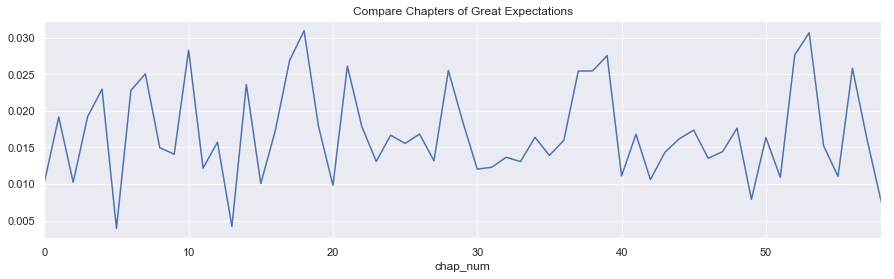

In [35]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of Great Expectations')

In [36]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [37]:
GE_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
GE_P.index.names = ['doc_x','doc_y']

In [38]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [39]:
GE_P['euclidean'] = 0
GE_P['euclidean'] = GE_P.apply(euclidean, 1)

In [40]:
GE_PME = GE_P.euclidean.unstack().fillna(0)

In [41]:
GE_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.136684,0.146777,0.143464,0.173361,0.187985,0.134595,0.129293,0.145528,0.145285,0.131092,...,0.157017,0.142154,0.146726,0.130140,0.141238,0.144207,0.154575,0.129322,0.147199,0.147954
1,0.000000,0.135415,0.118848,0.159096,0.171247,0.108463,0.110077,0.121335,0.126415,0.112656,...,0.143206,0.127844,0.130192,0.111761,0.126694,0.128806,0.140350,0.102185,0.129539,0.134496
2,0.000000,0.000000,0.141157,0.169597,0.187631,0.136486,0.129655,0.145881,0.146279,0.129554,...,0.156439,0.144024,0.146539,0.128509,0.141872,0.145314,0.154876,0.129912,0.147736,0.148894
3,0.000000,0.000000,0.000000,0.162080,0.174096,0.113844,0.115929,0.124869,0.131067,0.118501,...,0.148097,0.132767,0.134081,0.117901,0.132726,0.132682,0.144790,0.112960,0.132689,0.139984
4,0.000000,0.000000,0.000000,0.000000,0.203392,0.156299,0.153790,0.164424,0.166027,0.155125,...,0.177401,0.166447,0.168011,0.153905,0.163554,0.166881,0.174700,0.151886,0.167780,0.172096


In [42]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [43]:
GE_P['cosine'] = GE_P.apply(cosine, 1)
GE_PMC = GE_P.cosine.unstack().fillna(0)
GE_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000487,0.000887,0.000325,0.000478,0.000349,0.000304,0.000265,0.000260,0.000431,0.000211,...,0.000262,0.000319,0.000190,0.000267,0.000363,0.000220,0.000205,0.000279,0.000231,0.000517
1,0.000000,0.000572,0.000828,0.000564,0.000755,0.000803,0.000320,0.000819,0.000618,0.000238,...,0.000195,0.000171,0.000241,0.000281,0.000239,0.000172,0.000158,0.000791,0.000359,0.000346
2,0.000000,0.000000,0.000486,0.000807,0.000382,0.000173,0.000242,0.000234,0.000354,0.000318,...,0.000314,0.000171,0.000207,0.000378,0.000318,0.000139,0.000184,0.000239,0.000192,0.000435
3,0.000000,0.000000,0.000000,0.000632,0.000806,0.000802,0.000310,0.000903,0.000624,0.000225,...,0.000163,0.000179,0.000309,0.000250,0.000175,0.000245,0.000168,0.000502,0.000468,0.000285
4,0.000000,0.000000,0.000000,0.000000,0.000578,0.000464,0.000267,0.000555,0.000554,0.000228,...,0.000297,0.000164,0.000256,0.000317,0.000397,0.000192,0.000283,0.000441,0.000350,0.000291


## Cosine Similarity

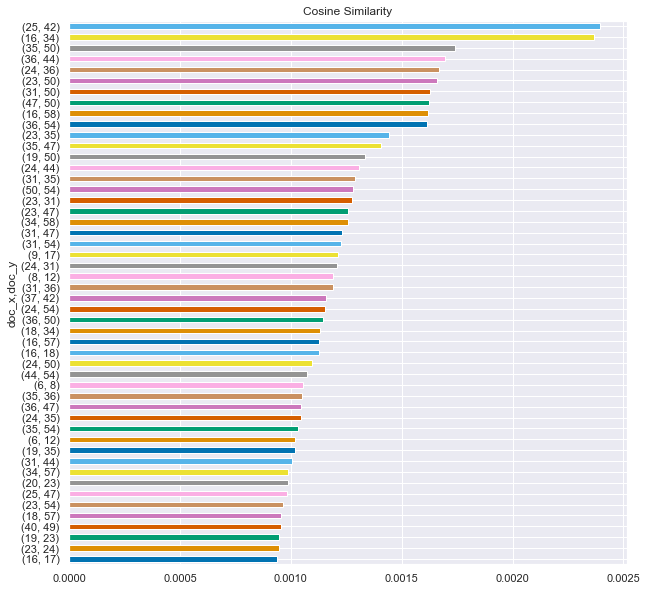

In [44]:
GE_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


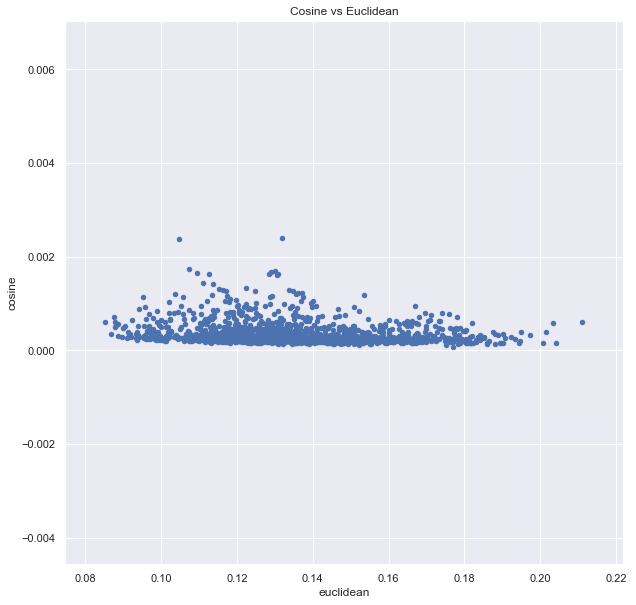

In [45]:
GE_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [46]:
import matplotlib.pyplot as plt

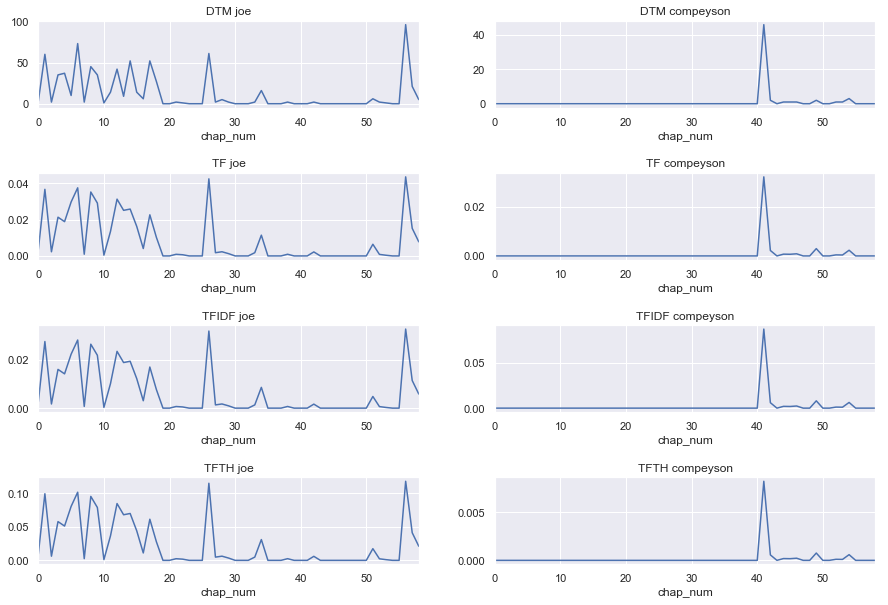

In [47]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('joe compeyson'.split()):
    W = get_term_id(GE_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

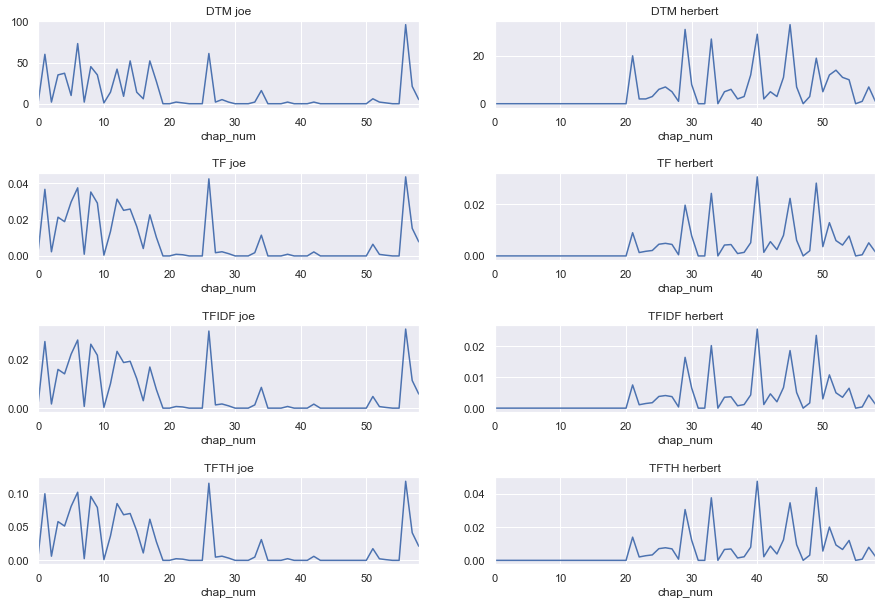

In [48]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('joe herbert'.split()):
    W = get_term_id(GE_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [49]:
GE_V.to_csv('Great_Expectations_V.csv', index=False)

## Visualize KDE Plots

In [50]:
GE_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0            NN   Chapter     0    0  chapter   
                           1           PRP         I     0    0        i   
         1        0        0          PRP$        My     0    0       my   
                           1            NN    father     0    0   father   
                           2           POS        's     0    0       's   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1562  
                           1             4816  
         1        0        0             6237  
                           1             3638  
                           2               54

In [51]:
lmk = GE_K.copy()

In [52]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                  
0        0        0        0          chapter     1562
                           1                i     4816
         1        0        0               my     6237
                           1           father     3638
                           2               's       54

In [53]:
K = tt.reset_index()

In [54]:
K.rename_axis('offset', inplace=True)

In [55]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,i,my,father,'s,family,name,being,pirrip,and,my
term_id,1562,4816,6237,3638,54,3601,6247,946,6976,435,6237


In [56]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [57]:
V1 = GE_V[(GE_V[vocab_weight] > GE_V[vocab_weight].quantile(vocab_weight_quantile)) & (GE_V.n >= vocab_min_n)]

In [58]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,5298,10479,1013,4617,5268,3052,10671,7402,3368,8594
term_str,joe,wemmick,biddy,herbert,jaggers,drummle,wopsle,pumblechook,estella,sister
n,745,284,231,313,242,88,119,163,270,170
p,0.00394506,0.00150389,0.00122323,0.00165745,0.00128148,0.000465993,0.00063015,0.000863146,0.00142975,0.000900214
port_stem,joe,wemmick,biddi,herbert,jagger,drumml,wopsl,pumblechook,estella,sister
stop,0,0,0,0,0,0,0,0,0,0
df,35,19,18,33,26,9,15,20,34,27
tf_sum,0.503518,0.225604,0.155138,0.243419,0.171727,0.0704195,0.0838054,0.104931,0.181558,0.123337
tf_mean,0.00853421,0.00382379,0.00262945,0.00412575,0.00291062,0.00119355,0.00142043,0.0017785,0.00307726,0.00209046
tf_max,0.043478,0.0294954,0.0426826,0.030526,0.0286121,0.0286656,0.0141195,0.0156249,0.0298987,0.0150985
tfidf_sum,0.37933,0.368798,0.265707,0.204046,0.203016,0.191028,0.165579,0.163768,0.144372,0.139094


In [59]:
TOP_TERMS = GE_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [60]:
TOP_TERMS

['joe',
 'wemmick',
 'biddy',
 'herbert',
 'jaggers',
 'drummle',
 'wopsle',
 'pumblechook',
 'estella',
 'sister',
 'mr',
 'havisham',
 'aged',
 'mrs',
 'provis',
 'miss',
 'compeyson',
 'sergeant',
 'dear',
 'handel',
 'sir',
 'skiffins',
 'orlick',
 'boy',
 'coach',
 'guardian',
 'gentleman',
 'convict',
 'father',
 'trabb']

In [61]:
K = K[K.term_id.isin(V1.index)]

In [62]:
K.head(11).T

offset,3,5,18,22,28,31,33,38,39,41,45
term_str,father,family,make,nothing,pip,called,pip,called,pip,give,father
term_id,3638,3601,5821,6388,6970,1404,6970,1404,6970,4199,3638


In [63]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [64]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [65]:
B.head()

,offset,x
term_str,,
'd,"[2535, 2580, 2628, 2776, 3471, 3604, 6360, 648...","[[2535], [2580], [2628], [2776], [3471], [3604..."
'em,"[1014, 7076, 11095, 11404, 11454, 18801, 26870...","[[1014], [7076], [11095], [11404], [11454], [1..."
'll,"[443, 1024, 2756, 3432, 3438, 3535, 4384, 4617...","[[443], [1024], [2756], [3432], [3438], [3535]..."
'm,"[6314, 7555, 14852, 17060, 18630, 27137, 50587...","[[6314], [7555], [14852], [17060], [18630], [2..."
're,"[853, 950, 4352, 4652, 6340, 6352, 6454, 11434...","[[853], [950], [4352], [4652], [6340], [6352],..."


In [66]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [67]:
B.head()

,offset,x,kde,scores
term_str,,,,
'd,"[2535, 2580, 2628, 2776, 3471, 3604, 6360, 648...","[[2535], [2580], [2628], [2776], [3471], [3604...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-11.935259369705012, -11.907642036178279, -11..."
'em,"[1014, 7076, 11095, 11404, 11454, 18801, 26870...","[[1014], [7076], [11095], [11404], [11454], [1...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.850003955533417, -12.820442829787078, -12..."
'll,"[443, 1024, 2756, 3432, 3438, 3535, 4384, 4617...","[[443], [1024], [2756], [3432], [3438], [3535]...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.366794326200097, -12.335734082568774, -12..."
'm,"[6314, 7555, 14852, 17060, 18630, 27137, 50587...","[[6314], [7555], [14852], [17060], [18630], [2...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-13.340597169675426, -13.288287191363914, -13..."
're,"[853, 950, 4352, 4652, 6340, 6352, 6454, 11434...","[[853], [950], [4352], [4652], [6340], [6352],...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.10181040504199, -12.072562180654685, -12...."


In [68]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

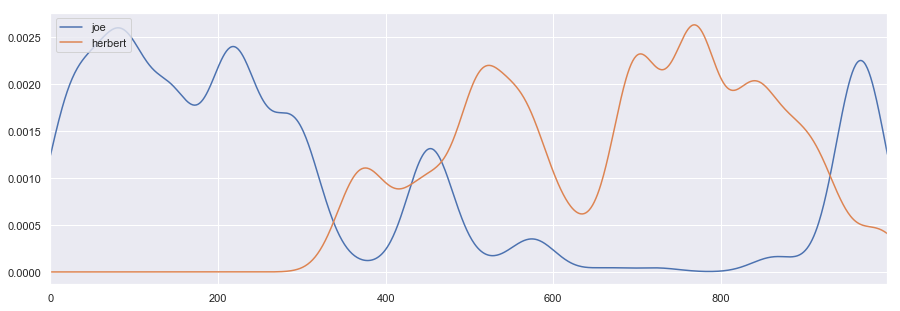

In [69]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['joe'].plot(**FIG)
PLOTS.loc['herbert'].plot(**FIG)
plt.legend(loc='upper left') 

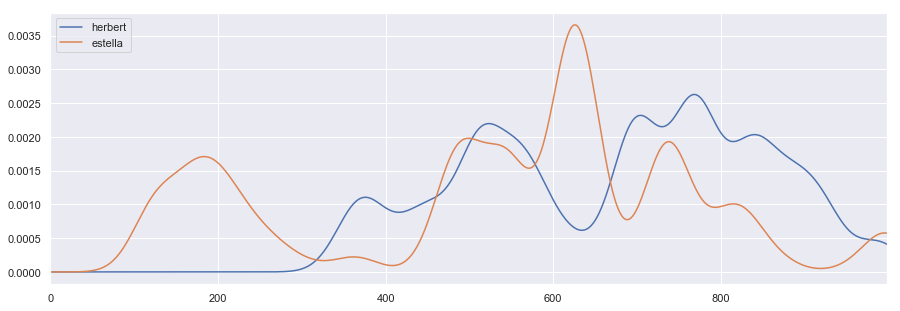

In [71]:
PLOTS.loc['herbert'].plot(**FIG)
PLOTS.loc['estella'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [72]:
WORDS = (GE_K.punc == 0) & (GE_K.num == 0) & GE_K.term_id.isin(GE_V[GE_V.stop==0].index)

In [73]:
BOW = GE_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [74]:
DTM = BOW.unstack().fillna(0)

In [75]:
alpha = .000001 
alpha_sum = alpha * GE_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [76]:
N_docs = DTM.shape[0]
GE_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / GE_V[GE_V.stop==0]['df'])

In [77]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,10803,10804,10806,10810,10811,10812,10813,10814,10815,10816
chap_num,,,,,,,,,,,,,,,,,,,,,
0,6.730631e-09,6.730631e-09,4.442329e-09,6.730631e-09,6.730631e-09,5.586480e-09,6.730631e-09,4.917195e-09,6.730631e-09,6.730631e-09,...,0.005365,3.518593e-09,4.442329e-09,3.298178e-09,5.586480e-09,6.730631e-09,6.730631e-09,5.586480e-09,6.730631e-09,6.730631e-09
1,3.591334e-09,3.591334e-09,2.370340e-09,3.591334e-09,3.591334e-09,2.980837e-09,3.591334e-09,2.623719e-09,3.591334e-09,3.591334e-09,...,0.001670,1.877453e-09,2.370340e-09,1.759844e-09,2.980837e-09,3.591334e-09,3.591334e-09,2.980837e-09,3.591334e-09,3.591334e-09
2,6.715264e-09,6.715264e-09,4.432187e-09,6.715264e-09,6.715264e-09,5.573725e-09,6.715264e-09,4.905968e-09,6.715264e-09,6.715264e-09,...,0.001784,3.510560e-09,4.432187e-09,3.290648e-09,5.573725e-09,6.715264e-09,6.715264e-09,5.573725e-09,6.715264e-09,6.715264e-09
3,3.580405e-09,3.580405e-09,2.363127e-09,3.580405e-09,3.580405e-09,2.971766e-09,3.580405e-09,2.615735e-09,3.580405e-09,3.580405e-09,...,0.001189,1.871741e-03,2.363127e-09,1.754490e-03,2.971766e-09,3.580405e-09,3.580405e-09,2.971766e-09,3.580405e-09,3.580405e-09
4,2.996745e-09,2.996745e-09,1.977902e-09,2.996745e-09,2.996745e-09,2.487324e-09,2.996745e-09,2.189331e-09,2.996745e-09,2.996745e-09,...,0.000796,1.566618e-09,1.977902e-09,1.468481e-09,2.487324e-09,2.996745e-09,2.996745e-09,2.487324e-09,2.996745e-09,2.996745e-09


## Principal Component Analysis

In [78]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [79]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,0.006185,-0.004919
1,0.017092,-0.001880
2,0.007855,-0.004818
3,0.017624,0.000453
4,0.026313,-0.008467
5,0.084653,0.118953
6,0.017040,-0.003232
7,0.003630,-0.002768
8,0.018595,-0.002884
9,0.017586,-0.002766


In [80]:
X = np.array(pca1)
X

array([[ 0.00618506, -0.0049193 ],
       [ 0.01709233, -0.00188011],
       [ 0.00785532, -0.00481822],
       [ 0.01762391,  0.00045287],
       [ 0.02631286, -0.00846738],
       [ 0.08465304,  0.11895256],
       [ 0.01703969, -0.00323207],
       [ 0.00363029, -0.00276769],
       [ 0.01859497, -0.00288407],
       [ 0.01758648, -0.00276577],
       [ 0.00032813, -0.00356004],
       [ 0.0114623 , -0.00619121],
       [ 0.01613296, -0.00445224],
       [ 0.04775659, -0.06706578],
       [ 0.013135  , -0.00532697],
       [ 0.01625944, -0.00530812],
       [ 0.01475016, -0.01649284],
       [ 0.00844212, -0.00387547],
       [ 0.0081513 , -0.00655556],
       [-0.02055781,  0.00691798],
       [-0.02423734,  0.00753521],
       [-0.00210238, -0.00201494],
       [-0.00124512, -0.00288913],
       [-0.03221736,  0.0138341 ],
       [-0.03234823,  0.01238128],
       [-0.01489395, -0.00018323],
       [ 0.01318425, -0.00402993],
       [ 0.00338205, -0.00089704],
       [ 0.00133527,

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [82]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [83]:
print(pca.explained_variance_)

[0.00046027 0.00038762]


In [84]:
print(pca.mean_)

[-2.20515696e-18  1.47010464e-19]


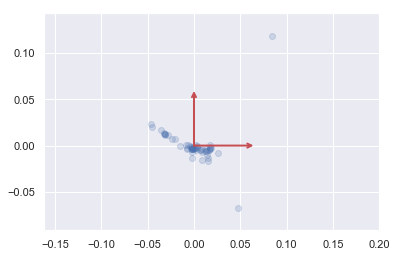

In [85]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [86]:
import sqlite3

In [87]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [88]:
text_db = 'db/Great_ Expectations.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [89]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [90]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [91]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [92]:
emo_cols = combo.columns

In [93]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [94]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [95]:
tokens = tokens.join(combo, on='term_str', how='left')

In [96]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
48        2         0         0            NaN
1         58        0         18           NaN
9         1         1         55           NaN
45        24        0         1            NaN
37        109       0         36           NaN
38        37        1         12           NaN
45        6         0         3           -1.0
28        7         1         19           NaN
7         4         1         18           NaN
53        50        0         41           NaN
Name: bing_sentiment, dtype: float64

In [97]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [98]:
tokens.head(10)

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0            NN   Chapter     0    0  chapter   
                           1           PRP         I     0    0        i   
         1        0        0          PRP$        My     0    0       my   
                           1            NN    father     0    0   father   
                           3            JJ         s     0    0        s   
                           4            NN    family     0    0   family   
                           5            NN      name     0    0     name   
                           6           VBG     being     0    0    being   
                           7           NNP    Pirrip     0    0   pirrip   
                           9            CC       and     0    0      and   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0             1480        0.0               0.0   
                           1             4740        0.0               0.0   
         1        0        0             6167        0.0               0.0   
                           1             3563        0.0               0.0   
                           3             8047        0.0               0.0   
                           4             3526        0.0               0.0   
                           5             6176        0.0               0.0   
                           6              862        0.0               0.0   
                           7             6904        0.0               0.0   
                           9              349        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
                           4                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   
                           6                  0.0       0.0      0.0   
                           7                  0.0       0.0      0.0   
                           9                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
                           4                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   
                           6                   0.0           0.0          0.0   
                           7                   0.0           0.0          0.0   
                           9                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0            0.0   
         1        0        0   

In [99]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

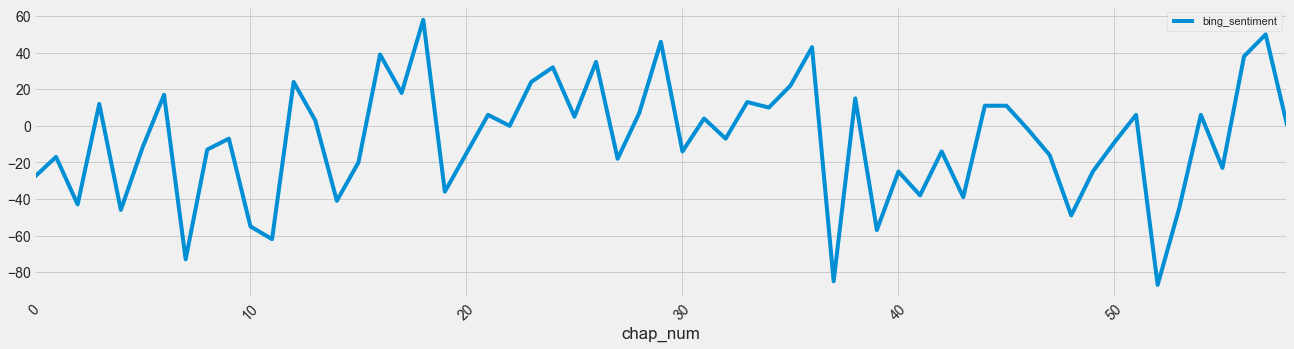

In [100]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [101]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [102]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [103]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0            <span class='sent0'>Chapter</span>
                              1                  <span class='sent0'>I</span>
          1         0         0                 <span class='sent0'>My</span>
                              1             <span class='sent0'>father</span>
                              3                  <span class='sent0'>s</span>
Name: html, dtype: object

In [104]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [105]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter i my father s family name being pirrip...,<span class='sent0'>Chapter</span> <span class...
1,chapter ii my sister mrs joe gargery was more ...,<span class='sent0'>Chapter</span> <span class...
2,chapter iii it was a rimy morning and very dam...,<span class='sent0'>Chapter</span> <span class...
3,chapter iv i fully expected to find a constabl...,<span class='sent0'>Chapter</span> <span class...
4,chapter v the apparition of a file of soldiers...,<span class='sent0'>Chapter</span> <span class...


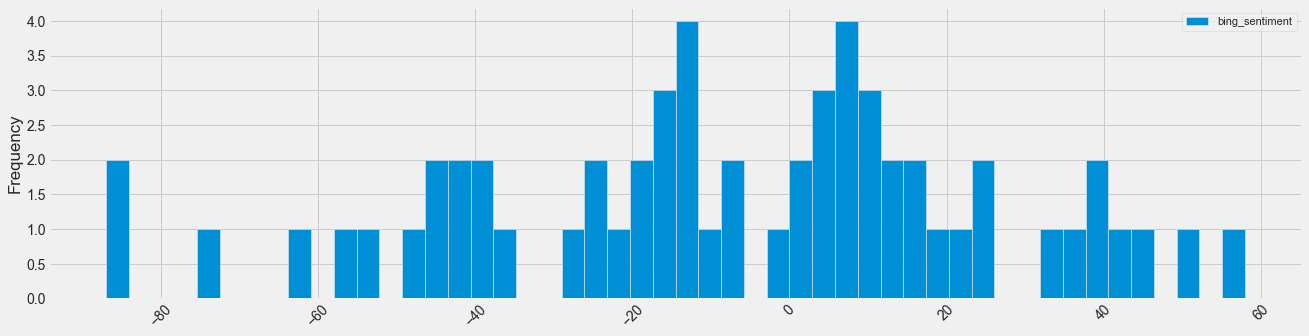

In [106]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [107]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
18,58.0,chapter xix morning made a considerable differ...
57,50.0,chapter lviii the tidings of my high fortunes ...
29,46.0,chapter xxx after well considering the matter ...
36,43.0,chapter xxxvii deeming sunday the best day for...
16,39.0,chapter xvii i now fell into a regular routine...
56,38.0,chapter lvii now that i was left wholly to mys...
26,35.0,chapter xxvii my dear mr pip i write this by r...
24,32.0,chapter xxv bentley drummle who was so sulky a...
23,24.0,chapter xxiv after two or three days when i ha...


### Negative

In [108]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
52,-87.0,chapter liii it was a dark night though the fu...
37,-85.0,chapter xxxviii if that staid old house near t...
7,-73.0,chapter viii mr pumblechook s premises in the ...
11,-62.0,chapter xii my mind grew very uneasy on the su...
39,-57.0,chapter xl it was fortunate for me that i had ...
10,-55.0,chapter xi at the appointed time i returned to...
48,-49.0,chapter xlix putting miss havisham s note in m...
4,-46.0,chapter v the apparition of a file of soldiers...
53,-45.0,chapter liv it was one of those march days whe...


### Multinomial Emotions

In [109]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [110]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


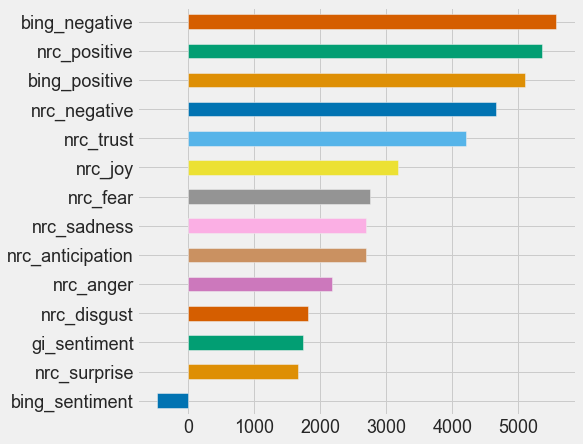

In [111]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [112]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [113]:
B.head()

,x
emo,
nrc_anger,"[[162], [178], [207], [257], [384], [418], [44..."
nrc_anticipation,"[[15], [73], [154], [335], [350], [434], [440]..."
nrc_disgust,"[[158], [418], [440], [453], [697], [706], [73..."
nrc_fear,"[[15], [181], [207], [257], [326], [335], [344..."
nrc_joy,"[[15], [73], [154], [216], [266], [284], [294]..."


In [114]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

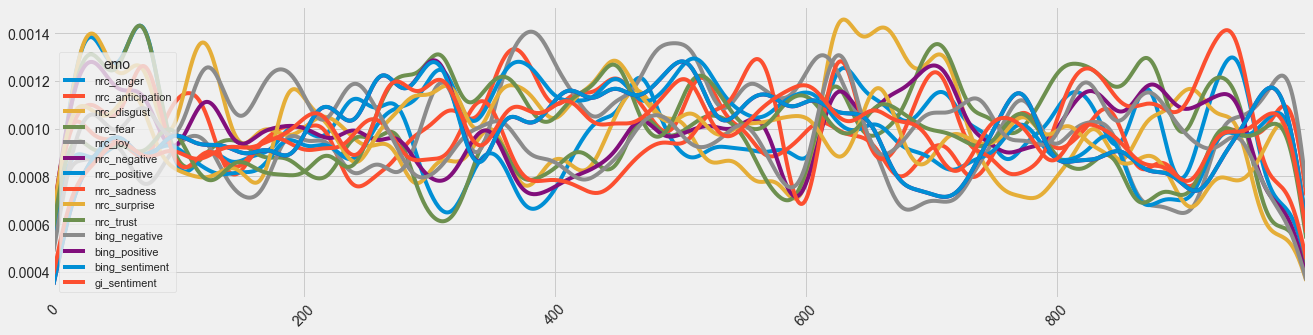

In [115]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

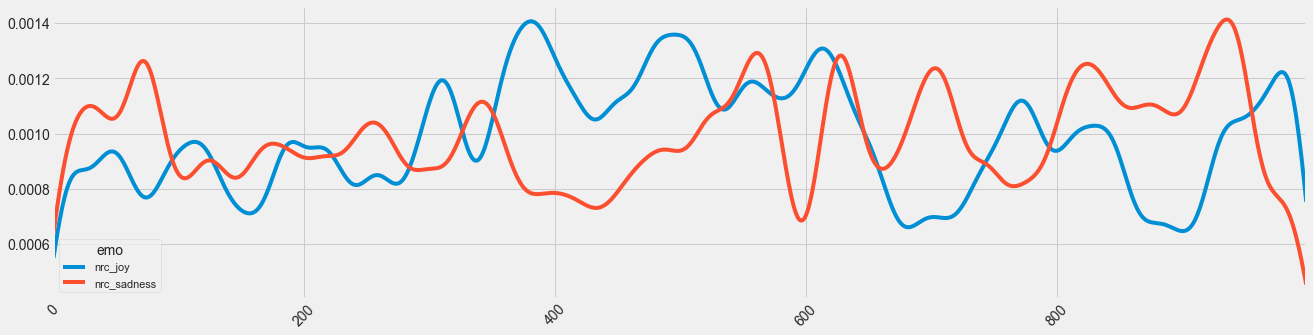

In [116]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

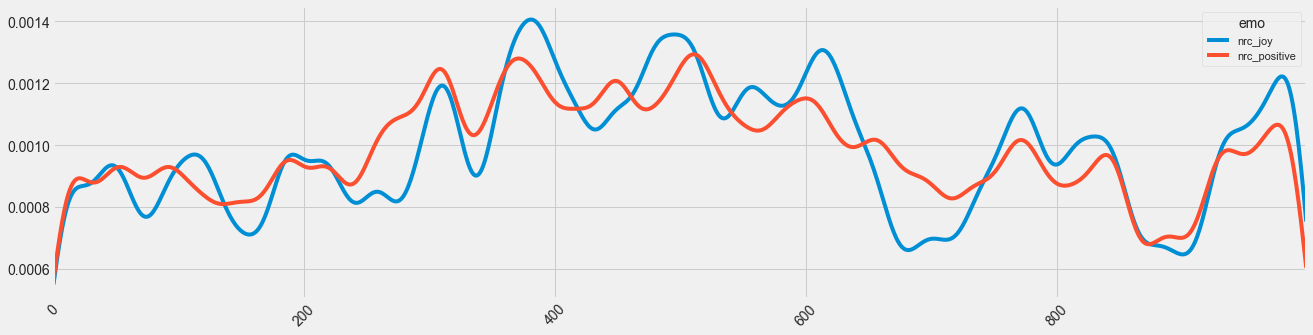

In [117]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

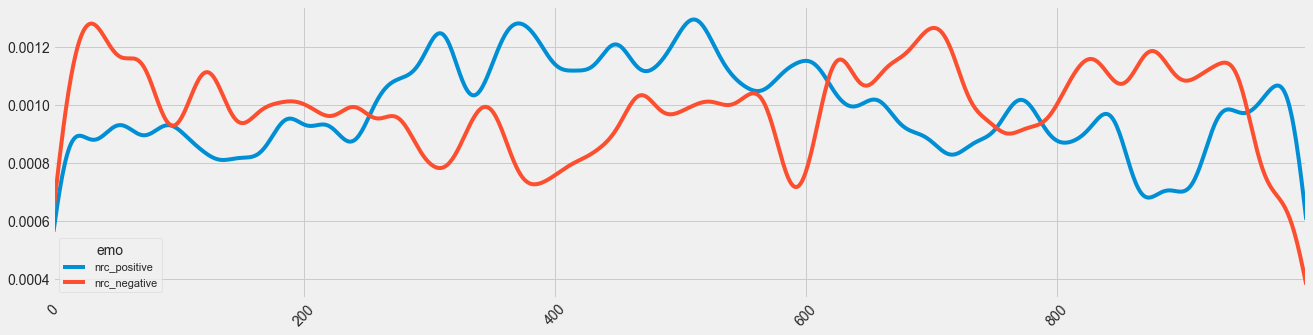

In [118]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

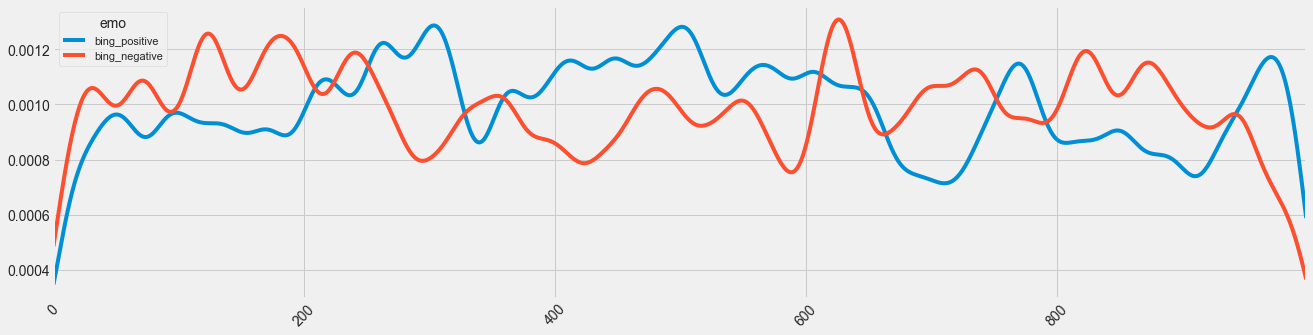

In [119]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)